In [1]:
from libraries import *
from utilities import load_img, tensor_to_image, imshow, gram_matrix
from one_punch_image import get_style
from vgg19_model import vgg_layers
from style_content_model import get_style_and_content_targets, get_extractor

In [2]:
content_path = '/Users/rudra_sarkar/Documents/Mtech Second Sem/Deep Learning/images/secret_of_steve_feature3-1130x480@2x.jpeg'

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-06-06 10:14:06.882889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-06 10:14:06.883975: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


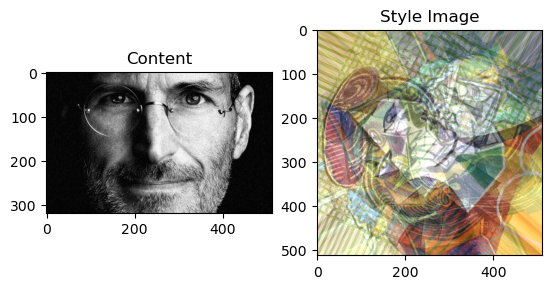

In [3]:
content_image = load_img(content_path, 'content')
style_image = get_style('picasso', True)

plt.subplot(1, 2, 1)
imshow(content_image, "Content")

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [6]:
content_layers = ['block5_conv2']
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [4]:
# extractor = StyleContentModel(style_layers, content_layers)
# style_targets = extractor(style_image)['style']
# content_targets = extractor(content_image)['content']

style_targets , content_targets = get_style_and_content_targets(style_image, content_image)

In [5]:
image = tf.Variable(content_image)
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


In [6]:
def style_content_loss(outputs):
    style_weight = 0.09
    content_weight = 1e4
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    num_style_layers = 5
    num_content_layers = 1
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                          for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers
    
    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name])**2)
                            for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = 1400*style_loss + 700*content_loss
    return loss

In [14]:
extractor = get_extractor()
@tf.function
def train_step(image):
    with tf.GradientTape() as tape:
        
        outputs = extractor(image)
        loss = style_content_loss(outputs)
    
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

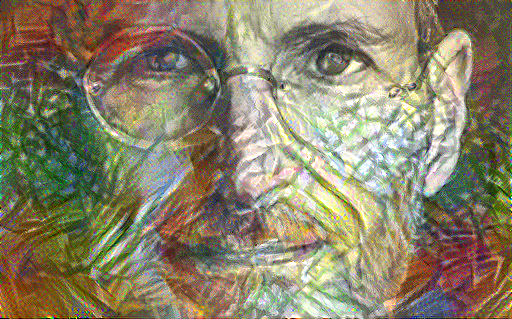

Train step: 4000
Total time: 1073.0


In [15]:
import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
display.display(tensor_to_image(image))

for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
#         print(".", end='', flush=False)
        
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))